In [1]:
import importlib
import local_utils; importlib.reload(local_utils)
from local_utils import *

Using TensorFlow backend.


Import time: 11.136674404144287
Import time: 5.507469177246094e-05


In [2]:
global_start = time()

In [3]:
train_df = pd.read_csv(DATA_DIR + '/train_v2.csv')
test_df = pd.read_csv(DATA_DIR + '/sample_submission_v2.csv')

label_map, inv_label_map, Y = process_labels(train_df)
print("Shape of Y {}".format(Y.shape))

train_inx, valid_inx = stratified_sampling(Y=Y, random_state=1000)
print("Train {}; Valid {};".format(len(train_inx), len(valid_inx)))

Shape of Y (40479, 17)
Train 36431; Valid 4048;


In [4]:
start = time()
main_train_feat = load_carray(DATA_DIR + '/models/main_train_feat.dat')
print(main_train_feat.shape)

vgg16_train_feat = load_carray(DATA_DIR + '/models/vgg16_train_feat.dat')
print(vgg16_train_feat.shape)

inceptionV3_train_feat = load_carray(DATA_DIR + '/models/inceptionV3_train_feat.dat')
print(inceptionV3_train_feat.shape)

resnet50_train_feat = load_carray(DATA_DIR + '/models/resnet50_train_feat.dat')
print(resnet50_train_feat.shape)
print(time() - start)

(40479, 6, 6, 256)
(40479, 6, 6, 512)
(40479, 6, 6, 2048)
(40479, 8, 8, 2048)
0.006681680679321289


In [6]:
model_name = "deep_model"

batch_size = 192
train_steps = np.ceil(len(train_inx)/batch_size)
valid_steps = np.ceil(len(valid_inx)/batch_size)

In [6]:
def train_generator(train_inx, batch_size):
    np.random.shuffle(train_inx)
    while 1:
        for i in range(0, len(train_inx), batch_size):
            yield [
                   main_train_feat[train_inx[i:i+batch_size]],
                   vgg16_train_feat[train_inx[i:i+batch_size]],
                   inceptionV3_train_feat[train_inx[i:i+batch_size]],
                   resnet50_train_feat[train_inx[i:i+batch_size]]], Y[train_inx[i:i+batch_size]]
                
def valid_generator(valid_inx, batch_size):
    while 1:
        for i in range(0, len(valid_inx), batch_size):
            yield [
#                    main_train_feat[valid_inx[i:i+batch_size]],
#                    vgg16_train_feat[valid_inx[i:i+batch_size]],
                   inceptionV3_train_feat[valid_inx[i:i+batch_size]],
                   resnet50_train_feat[valid_inx[i:i+batch_size]]], Y[valid_inx[i:i+batch_size]]

In [4]:
class F2History(Callback):
    def on_train_begin(self, logs={}):
        self.f2_scores = []
    def on_epoch_end(self, epoch, logs ={}):
        p_valid = self.model.predict_generator(valid_generator(valid_inx, batch_size), valid_steps)
        y_val = Y[valid_inx]
        f2 = fbeta_score(y_val, np.array(p_valid) >= 0.2, beta=2, average='samples')
        print()
        print("F2 Score {}".format(f2))
        self.f2_scores.append(f2)
        return

f2_history = F2History()

In [7]:
model_checkpoint = ModelCheckpoint(
                DATA_DIR + '/models/' + model_name + '.h5', 
                monitor='val_loss', 
                verbose=1, 
                save_best_only=True, 
                save_weights_only=False, 
                mode='min',
                period=1)

In [10]:
p = 0.5
main_input = Input(shape=(6, 6, 256))
vgg16_input = Input(shape=(6, 6, 512))
inceptionV3_input = Input(shape=(6, 6, 2048))
resnet50_input = Input(shape=(8, 8, 2048))

main_x = BatchNormalization()(main_input)
main_x = Dropout(0.75)(main_x)
main_x = Conv2D(128, (3, 3), padding='same')(main_x)
main_x = MaxPooling2D()(main_x)

vgg16_x = BatchNormalization()(vgg16_input)
vgg16_x = Conv2D(128, (3, 3), padding='same')(vgg16_x)
vgg16_x = MaxPooling2D()(vgg16_x)

inceptionV3_x = BatchNormalization()(inceptionV3_input)
inceptionV3_x = Conv2D(128, (3, 3), padding='same')(inceptionV3_x)
inceptionV3_x = MaxPooling2D()(inceptionV3_x)

resnet50_x = BatchNormalization()(resnet50_input)
resnet50_x = Conv2D(128, (3, 3))(resnet50_x)
resnet50_x = AveragePooling2D()(resnet50_x)

x = concatenate([main_x, vgg16_x, inceptionV3_x, resnet50_x])

x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = GlobalMaxPooling2D()(x)

x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = Dense(512, activation='relu')(x)

x = BatchNormalization()(x)
x = Dropout(p/4)(x)
output = Dense(17, activation='sigmoid')(x)

# x = BatchNormalization()(x)
# x = Dropout(p/2)(x)
# x = Conv2D(17, (3, 3), padding='same')(x)
# x = GlobalMaxPooling2D()(x)
# output = Activation('sigmoid')(x)

model = Model(inputs=[main_input, vgg16_input, inceptionV3_input, resnet50_input], outputs=output)

In [11]:
opt = optimizers.Adam(lr=1e-3, decay=75e-5)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, 6, 6, 256)     0                                            
____________________________________________________________________________________________________
batch_normalization_9 (BatchNorm (None, 6, 6, 256)     1024        input_9[0][0]                    
____________________________________________________________________________________________________
input_10 (InputLayer)            (None, 6, 6, 512)     0                                            
____________________________________________________________________________________________________
input_11 (InputLayer)            (None, 6, 6, 2048)    0                                            
___________________________________________________________________________________________

In [11]:
model.fit_generator(
    generator=train_generator(train_inx, batch_size),
    steps_per_epoch=train_steps,
    epochs=10,
    verbose=1,
    validation_data=valid_generator(valid_inx, batch_size),
    validation_steps=valid_steps,
    callbacks=[f2_history, model_checkpoint])

Epoch 1/10
189/190 [============================>.] - ETA: 0s - loss: 0.3264 - acc: 0.8648
F2 Score 0.8759348375879408
Epoch 00000: val_loss improved from inf to 0.13653, saving model to /src/DL/planet_understanding_the_amazon_from_space/data/models/deep_model.h5
190/190 [==============================] - 60s - loss: 0.3255 - acc: 0.8652 - val_loss: 0.1365 - val_acc: 0.9489
Epoch 2/10
189/190 [============================>.] - ETA: 0s - loss: 0.1344 - acc: 0.9505
F2 Score 0.8896632563002944
Epoch 00001: val_loss improved from 0.13653 to 0.12295, saving model to /src/DL/planet_understanding_the_amazon_from_space/data/models/deep_model.h5
190/190 [==============================] - 57s - loss: 0.1344 - acc: 0.9505 - val_loss: 0.1229 - val_acc: 0.9534
Epoch 3/10
189/190 [============================>.] - ETA: 0s - loss: 0.1216 - acc: 0.9544
F2 Score 0.891691258683401
Epoch 00002: val_loss improved from 0.12295 to 0.11999, saving model to /src/DL/planet_understanding_the_amazon_from_space/d

[0.87593483758794077, 0.88966325630029441, 0.89169125868340104, 0.89480947075785267, 0.89322412151809361, 0.89564953998476149, 0.89514037825174853, 0.88847522267952417, 0.8915139585679932, 0.89234566961691431]


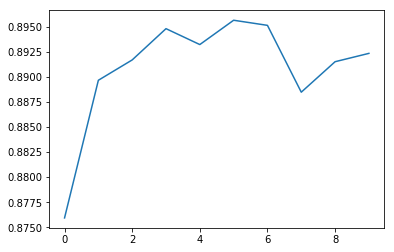

In [14]:
print(f2_history.f2_scores)
plt.plot(f2_history.f2_scores)
plt.show()

In [13]:
stop

NameError: name 'stop' is not defined

In [ ]:
# model.save(DATA_DIR + '/models/' + model_name + '.h5')

del model
model = load_model(DATA_DIR + '/models/' + model_name + '.h5', compile=False)
opt = optimizers.Adam(lr=1e-3, decay=1e-4)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.evaluate_generator(valid_generator(valid_inx, batch_size), valid_steps)

In [ ]:
p_X_valid = model.predict_generator(valid_generator(valid_inx, batch_size), valid_steps, verbose=1)

In [ ]:
start = time()
thres = find_best_thresholds(Y[valid_inx], p_X_valid)
save_array(DATA_DIR + '/models/' + model_name + '_thres.dat', thres)
print(time() - start)

In [ ]:
print(f2_score(Y[valid_inx], p_X_valid, thres))
# print(f2_score(Y, p_X, thres))
# print(f2_score(Y[train_inx], p_X[train_inx], thres))
# print(f2_score(Y[valid_inx], p_X[valid_inx], thres))

In [ ]:
del main_train_feat
del vgg16_train_feat
del inceptionV3_train_feat
del resnet50_train_feat
del p_X_valid

start = time()
batch_size = 128
model = load_model(DATA_DIR + '/models/' + model_name + '.h5', compile=False)
thres = load_array(DATA_DIR + '/models/' + model_name + '_thres.dat')

main_test_feat = load_carray(DATA_DIR + '/models/main_test_feat.dat')
print(main_test_feat.shape)

vgg16_test_feat = load_carray(DATA_DIR + '/models/vgg16_test_feat.dat')
print(vgg16_test_feat.shape)

inceptionV3_test_feat = load_carray(DATA_DIR + '/models/inceptionV3_test_feat.dat')
print(inceptionV3_test_feat.shape)

resnet50_test_feat = load_carray(DATA_DIR + '/models/resnet50_test_feat.dat')
print(resnet50_test_feat.shape)
print(time() - start)

In [ ]:
test_steps = np.ceil(len(test_df)/batch_size)
def test_generator(batch_size):
    while 1:
        for i in range(0, len(main_test_feat), batch_size):
            yield [main_test_feat[i:i+batch_size],
                   vgg16_test_feat[i:i+batch_size],
                   inceptionV3_test_feat[i:i+batch_size],
                   resnet50_test_feat[i:i+batch_size]]

In [ ]:
p_X_test = model.predict_generator(test_generator(batch_size), test_steps, verbose=1)

In [ ]:
start = time()
for inx in np.arange(len(test_df)):
    test_df['tags'][inx] = ' '.join([inv_label_map[i] for i, b in enumerate(p_X_test[inx] >= thres) if b])
print(time() - start)

test_df.head()

In [ ]:
test_df.to_csv(DATA_DIR + '/results/' + model_name + '_submission.csv', index=False)
FileLink('data/results/' + model_name + '_submission.csv')

In [ ]:
print((time() - global_start)/60)